In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math

In [70]:
# base params
kon = 1e5
koff = 1e-4
Target_cell_number = 5e3
qon = 6.5e3
qoff = 4.7e-3
k1off = koff
k2off = 2*koff
k3off = qoff
k4off = qoff
k5off = qoff
k6off = koff
k7off = 2*koff
gamma2 = k2off/k1off
gamma3 = k3off/k1off
gamma4 = k4off/k1off
gamma5 = k5off/k1off
gamma6 = k6off/k1off
gamma7 = k7off/k1off

tend = 100
t = np.geomspace(1e-10, tend, 1000)
tspan = [1e-10, tend]

rtot_t = 1e5
rtot_f = 2.2e5
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
r_ab = 1.25e-8
NK_cell_radius = 3e-6
Nk_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
reaction_volume1 = (2/3)*math.pi*((r_ab)**3)
reaction_volume2 = (2/3)*math.pi*((0.5*r_ab)**3)
reaction_volume3 = (2/3)*math.pi*((r_ab)**3)
reaction_volume_4 = (1/3)*math.pi*((r_ab)**3)
target_effect_conc2 = (rtot_t)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume2)
t_end1 = 1
t1 = np.geomspace(1e-10, t_end1, 100)
t_span1 = [0, t_end1]

In [79]:
(math.pi*((r_ab)**2))/(4*math.pi*((NK_cell_radius)**2))

4.340277777777777e-06

In [71]:
def target_cell_model(t, z, A0, rtot, kon):
    k = kon*A0
    alpha = k/koff
    Atot = 1e16*A0/Target_cell_number
    beta = Atot/rtot
    target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)
    k2 = target_effective_conc1*kon
    alpha2 = k2/koff
    dA1 = 2*alpha*(1-z[0]-2*z[1])*(beta-z[0]-z[1]) - z[0] - alpha2*(1-z[0]-2*z[1])*z[0] + 2*z[1]
    dA2 = alpha2*(1-z[0]-2*z[1])*z[0] - 2*z[1]

    return [dA1, dA2]

def NK_cell(t, z, A_0, Atot_system, E_T_ratio, rtot_f):
    q = A_0*qon
    sigma = q/koff
    epsilon = qoff/koff
    Atot_effector = Atot_system/E_T_ratio
    eta = Atot_effector/rtot_f

    return sigma*(eta-z)*(1-z) - epsilon*z


def single_cell_stst(A_0, rtot):

    z0 = [0, 0]

    # solve single cell model to obtain equilibrium values
    # to use as ics for A10 and A20 in two cell model
    z = solve_ivp(target_cell_model, tspan, z0, method='Radau', args=(A_0, rtot, kon), t_eval=t)
    A1 = z.y[0]
    A2 = z.y[1]
    A1_stst = A1[-1]
    A2_stst = A2[-1]
    
    return [A1_stst, A2_stst]

def NK_cell_IC(A_0, A1_stst, A2_stst, E_T_ratio, rtotff):

    Atot = 1e16*A_0/Target_cell_number
    beta = Atot/rtot_t

    A0 = beta - A1_stst - A2_stst
    A0_IC = A0*Atot

    z1 = solve_ivp(NK_cell, t_span1, [0], method='Radau', args=(A_0, A0_IC, E_T_ratio, rtotff), t_eval=t1)

    A1f = z1.y[0]

    return A1f[-1]

def two_cells(t, z, phi, A_0, A10_0, A20_0, rtotf, rtott, kon, A01_0):

    Ainit = A_0
    k = Ainit*kon
    q = qon*Ainit
    target_effect_conc2 = (rtotf)*(Nk_cell_surface_area)*(1/N_A)/(reaction_volume1)
    target_effect_conc3 = (rtotf)*(Nk_cell_surface_area)*(1/N_A)/(reaction_volume2)
    target_effective_conc1 =(rtott)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)
    target_effect_conc6 = (rtott)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)
    target_effect_conc7 = (rtott)*(tumour_cell_surface_area*(1/N_A))/(reaction_volume2)
    k2 = target_effective_conc1*kon
    k4 = target_effect_conc2*qon
    k5 = target_effect_conc3*qon
    k6 = 2*target_effect_conc6*kon
    k7 = target_effect_conc7*kon
    k1 = 2*k
    k3 = q

    alpha1 = k1/k1off
    alpha2 = k2/k1off
    alpha3 = k3/k1off
    alpha4 = k4/k1off
    alpha5 = k5/k1off
    alpha6 = k6/k1off
    alpha7 = k7/k1off

    beta_synapse = 1e1*Ainit
    beta_t = beta_synapse + A10_0 + A20_0 + (A01_0/phi)
    beta_f = phi*beta_t
    
    A00 = (1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4] + (1/phi)*z[2]))
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])
    
    dA10 = alpha1*beta_t*(A00)*(rt) - z[0] - alpha2*z[0]*(rt) + gamma2*z[1] - alpha4*z[0]*(rf) + gamma4*z[3]
    dA20 = alpha2*z[0]*(rt) - gamma2*z[1] - alpha5*z[1]*(rf) + gamma5*z[4]
    dA01 = alpha3*beta_f*(A00)*(rf) - gamma3*z[2] - alpha6*z[2]*(rt) + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma4*z[3] + (alpha6/phi)*z[2]*(rt) - gamma6*z[3] - alpha7*z[3]*(rt) + gamma7*z[4]
    dA21 = alpha5*z[1]*(rf) - gamma5*z[4] + alpha7*z[3]*(rt) - gamma7*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [72]:
Ainit = 1e-6
rtot_t = 5e6*0.035
rtot_f = 2.2e5/4
phi = rtot_t/rtot_f
rtott = 5e6
rtotff = 2.2e5
E_T_ratio = 10

ICS = single_cell_stst(Ainit, rtott)
A10_0 = ICS[0]
A20_0 = ICS[1]
A01_0 = NK_cell_IC(Ainit, A10_0, A20_0, E_T_ratio, rtotff)
beta_t = 1e1*Ainit + A10_0 + A20_0 + (A01_0/phi)
beta_f = beta_t*phi
z0 = [A10_0, A20_0, A01_0, 0, 0]

z = solve_ivp(two_cells, tspan, z0, method='Radau', t_eval=t, args=(phi, Ainit, A10_0, A20_0, rtotff, rtott, kon, A01_0))


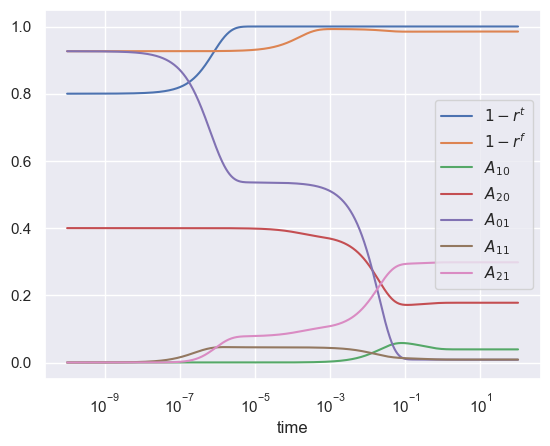

In [73]:
A00_vals = (1 - (1/beta_t)*(z.y[0] + z.y[1] + z.y[3] + z.y[4] + (1/phi)*z.y[2]))
rt_vals = 1-(1- z.y[0] - z.y[3] - 2*(z.y[1] + z.y[4]))
rf_vals = (1-(1 - z.y[2] - phi*(z.y[3] + z.y[4])))

sns.set_theme()
#plt.plot(t, A00_vals, label = r'$A_{00}$')
plt.plot(t, rt_vals, label = r'$1 - r^t$')
plt.plot(t, rf_vals, label = r'$1 - r^f$')
plt.plot(t, z.y[0], label = r'$A_{10}$')
plt.plot(t, z.y[1], label = r'$A_{20}$')
plt.plot(t, z.y[2], label = r'$A_{01}$')
plt.plot(t, z.y[3], label = r'$A_{11}$')
plt.plot(t, z.y[4], label = r'$A_{21}$')
plt.xlabel('time')
plt.xscale('log')
plt.legend(loc='best')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/Synapse_case2_ModelR_1e-5')

In [74]:
vals = np.linspace(1, 9, 50)
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
A0s = []

for x in A0s1:
    for val in vals:
        A0s.append(x*val)

rtot_f = 2.2e5/4

A10_stst = np.zeros_like(A0s)
A20_stst = np.zeros_like(A0s)
A01_stst = np.zeros_like(A0s)
A11_stst = np.zeros_like(A0s)
A21_stst = np.zeros_like(A0s)
A00_stst = np.zeros_like(A0s)
fc_num_per = np.zeros_like(A0s)
fc_num = np.zeros_like(A0s)
fc_max = np.zeros_like(A0s)
A1_max = np.zeros_like(A0s)
A2_max = np.zeros_like(A0s)
fc_max_time = np.zeros_like(A0s)
A1_max_time = np.zeros_like(A0s)
A2_max_time = np.zeros_like(A0s)

rtots = [1e5, 5e5, 1e6, 5e6]
r_sols = []
for val in rtots:
    rtot_t = val*0.035
    phi = rtot_t/rtot_f
    fc_num = np.zeros_like(A0s)
    for i in range(len(A0s)):
        A0 = A0s[i]
        ICS = single_cell_stst(A0, val)
        A10_0 = ICS[0]
        A20_0 = ICS[1]
        A01_0 = NK_cell_IC(A0, A10_0, A20_0, E_T_ratio, rtotff)
        beta_t = 1e1*A0 + A10_0 + A20_0 + (A01_0/phi)
        beta_f = beta_t*phi
        z0 = [A10_0, A20_0, A01_0, 0, 0]

        z = solve_ivp(two_cells, tspan, z0, method='Radau', t_eval=t, args=(phi, Ainit, A10_0, A20_0, rtotff, rtott, kon, A01_0))

        A20 = z.y[1]
        A21 = z.y[4]
        A10 = z.y[0]
        A11 = z.y[3]
        A01 = z.y[2]
        A00 = (1 - (1/beta_t)*(z.y[0] + z.y[1] + z.y[3] + z.y[4] + (1/phi)*z.y[2]))

        A10_stst[i] = A10[-1]
        A20_stst[i] = A20[-1]
        A01_stst[i] = A01[-1]
        A11_stst[i] = A11[-1]
        A21_stst[i] = A21[-1]
        A00_stst[i] = A00[-1]
        fc_num[i] = A21[-1] + A11[-1]
        A1_max[i] = np.max(A11)
        A2_max[i] = np.max(A21)
        fc_max[i] = np.max(A11 + A21)
        A1_max_time[i] = t[np.argmax(np.round(A11, 3))]
        A2_max_time[i] = t[np.argmax(np.round(A21, 3))]
        fc_max_time[i] = t[np.argmax(np.round(A11 + A21, 3))]
    r_sols.append(fc_num)
    

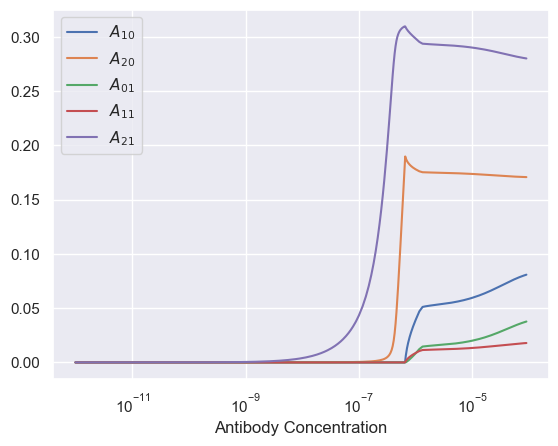

In [75]:
#plt.plot(A0s, A00_stst, label = r'$A_{00}$')
plt.plot(A0s, A10_stst, label = r'$A_{10}$')
plt.plot(A0s, A20_stst, label = r'$A_{20}$')
plt.plot(A0s, A01_stst, label = r'$A_{01}$')
plt.plot(A0s, A11_stst, label = r'$A_{11}$')
plt.plot(A0s, A21_stst, label = r'$A_{21}$')
plt.xlabel('Antibody Concentration')
plt.xscale('log')
plt.legend(loc='best')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/Synapse_case2_ModelR_stst')

Text(0.5, 1.0, 'Fc Curves')

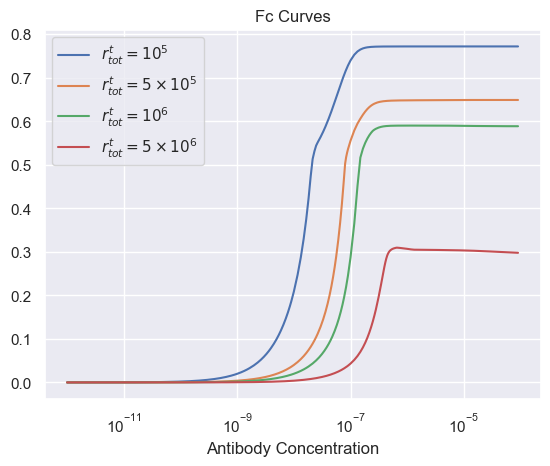

In [76]:
labels = [r'$r_{tot}^t = 10^5$', r'$r_{tot}^t = 5\times 10^5$', r'$r_{tot}^t = 10^6$', r'$r_{tot}^t = 5 \times 10^6$']
for i in range(len(r_sols)):
    plt.plot(A0s, r_sols[i], label=labels[i])

plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Antibody Concentration')
plt.title('Fc Curves')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/Synapse_case2_ModelR_stst_var_rtot')